# 1. Reading from Camera

We can use Colab to access webcam through JavaScript (because everythong is happend in a browser)

In [0]:
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode

def take_photo(filename='test_chess.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      // Prompts the user for permission to use a camera
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)
  data = eval_js('takePhoto({})'.format(quality))
  binary = b64decode(data.split(',')[1])
  with open(filename, 'wb') as f:
    f.write(binary)
  return filename

In [0]:
from IPython.display import Image
try:
  filename = take_photo()
  print('Saved to {}'.format(filename))
  
  # Show the image which was just taken.
  display(Image(filename))
except Exception as err:
  # Errors will be thrown if the user does not have a webcam or if they do not
  # grant the page permission to access it.
  print(str(err))

<IPython.core.display.Javascript object>

KeyboardInterrupt: ignored

# 2. Camera parameters

#### Setup

Chessboard img set by OpenCV [for those of you too lazy to make their own]
https://github.com/opencv/opencv/tree/master/samples/data


Chessboard to print https://drive.google.com/drive/folders/1sC2W7THurqaMB14sSq5auFjvXYzMEc-z?usp=sharing

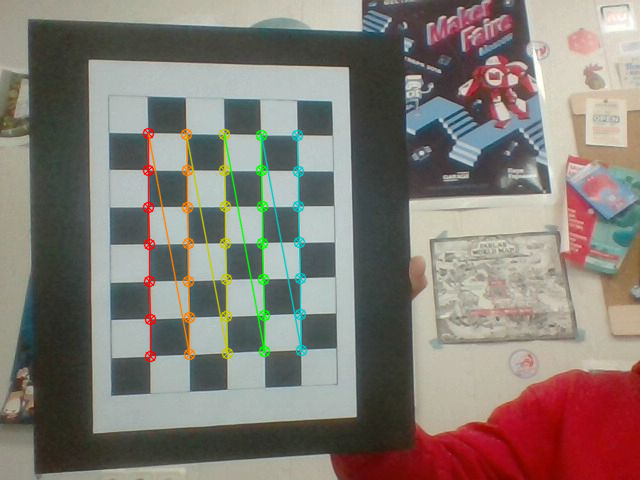

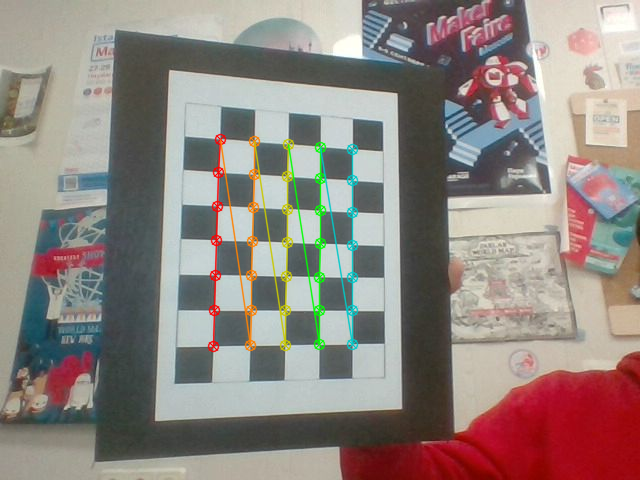

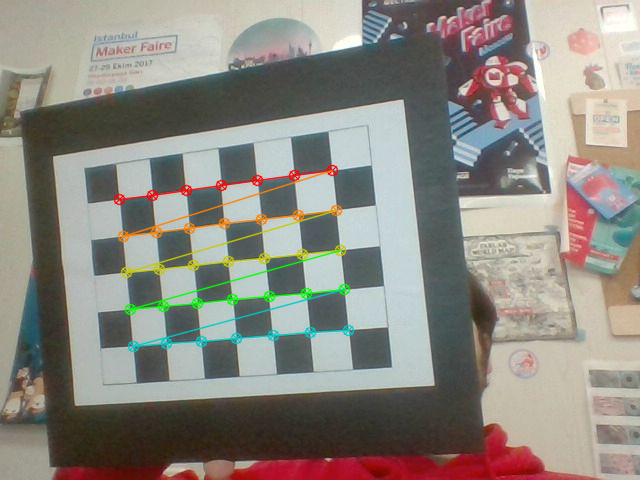

In [0]:
import numpy as np
import cv2
import glob
from google.colab.patches import cv2_imshow

# termination criteria
# TERM_CRITERIA_EPS - stop the algorithm iteration if specified accuracy, epsilon, is reached
# TERM_CRITERIA_MAX_ITER - stop the iteration when any of the above condition is met

max_iter = 30 # An integer specifying maximum number of iterations.
epsilon = 0.001 # Epsilon - required accuracy

criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, max_iter, epsilon)

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0) - they could be set in mmm but it's fine!
objp = np.zeros((5*7,3), np.float32)
objp[:,:2] = np.mgrid[0:7,0:5].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d point in real world space
imgpoints = [] # 2d points in image plane

images = glob.glob('*.jpg') # takes all .jpg file's paths in current folder

for fname in images:
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Find the chess board corners
    ret, corners = cv2.findChessboardCorners(gray, (7,5),None)

    # If found, add object points, image points (after refining them)
    if ret == True:
        objpoints.append(objp)

        corners2 = cv2.cornerSubPix(gray,corners,(11,11),(-1,-1),criteria)
        imgpoints.append(corners2)

        # Draw and display the corners
        img = cv2.drawChessboardCorners(img, (7,5), corners2,ret)
        cv2_imshow(img)

#### Calibration

So now we have our object points and image points we are ready to go for calibration. For that we use the function, cv2.calibrateCamera(). It returns the camera matrix, distortion coefficients, rotation and translation vectors etc.

Finds the camera intrinsic and extrinsic parameters from several views of a calibration pattern.





In [0]:
# ret - boolean if goes ok
# mtx - camera matrix A or M
# dst - distortion coefficients
# rvecs - rotation vectors
# tvecs - translation vectors
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1],None,None)

We can save and than download all parameters as numpy arrays (.npy files) tb reused

In [0]:
! mkdir params

In [0]:
savedir = 'params/'
print("Camera Matrix")
print(mtx)
np.save(savedir+'mtx.npy', mtx)

print("Distortion Coeff")
print(dist)
np.save(savedir + 'dist.npy', dist)

print("r vecs")
print(rvecs)

print("t vecs")
print(tvecs)

Camera Matrix
[[552.31284995   0.         356.36155489]
 [  0.         549.93296874 246.81452222]
 [  0.           0.           1.        ]]
Distortion Coeff
[[-0.00253049 -0.05274618 -0.0006391  -0.00084426  0.15296735]]
r vecs
[array([[ 0.10300097],
       [-0.13898379],
       [-1.5845302 ]]), array([[ 0.10366706],
       [-0.29404022],
       [-1.54442001]]), array([[-0.01071988],
       [ 0.20756564],
       [-0.10400638]])]
t vecs
[array([[-5.49355501],
       [ 2.92480055],
       [14.70367935]]), array([[-3.99429405],
       [ 2.78130275],
       [15.41307684]]), array([[-6.44177904],
       [-1.29450002],
       [14.9925734 ]])]


#### Undistortion

Now we can take an image and undistort it.

we can refine the camera matrix based on a free scaling parameter using cv2.getOptimalNewCameraMatrix(). If the scaling parameter alpha=0, it returns undistorted image with minimum unwanted pixels. So it may even remove some pixels at image corners. If alpha=1, all pixels are retained with some extra black images. It also returns an image ROI which can be used to crop the result.



0. So we take a new image **test.jpg** in this case.

newCameraMatrix – Camera matrix of the distorted image. By default, it is the same as cameraMatrix but you may additionally scale and shift the result by using a different matrix

In [0]:
img = cv2.imread('test_img/test_chess.jpg')
h,  w = img.shape[:2]
newcameramtx, roi = cv2.getOptimalNewCameraMatrix(mtx,dist,(w,h),1,(w,h))

1. Using cv2.undistort()

This is the shortest path. Just call the function and use ROI obtained above to crop the result.




(4, 4, 634, 473)


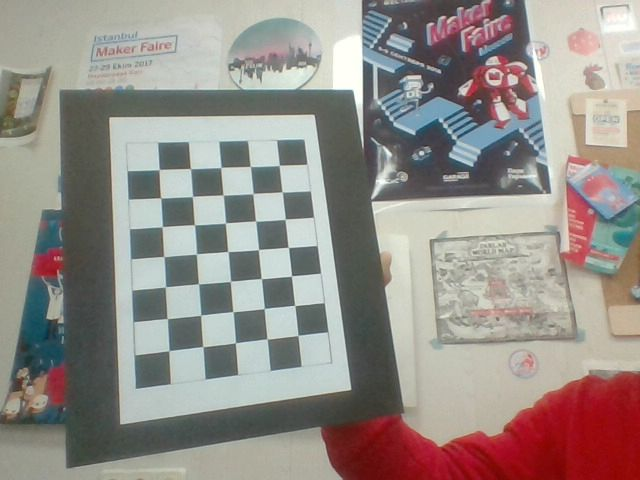

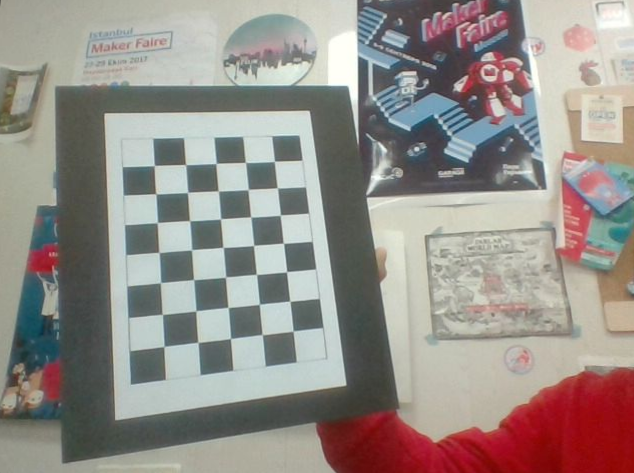

In [0]:
# undistort
dst = cv2.undistort(img, mtx, dist, None, newcameramtx)

# crop the image
x,y,w,h = roi
print(roi)
dst = dst[y:y+h, x:x+w]
cv2.imwrite('undist_chess.png', dst)
cv2_imshow(img)
cv2_imshow(dst)

3. Now let's undistort acrylic image

In [0]:
img2 = cv2.imread('test_img/acrylic_ref.jpg')
h2,  w2 = img2.shape[:2]
newcameramtx2, roi2 = cv2.getOptimalNewCameraMatrix(mtx,dist,(w2,h2),1,(w2,h2))

(4, 4, 634, 473)


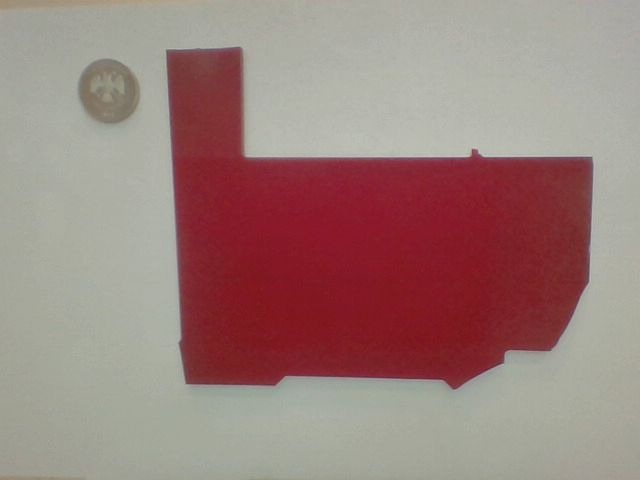

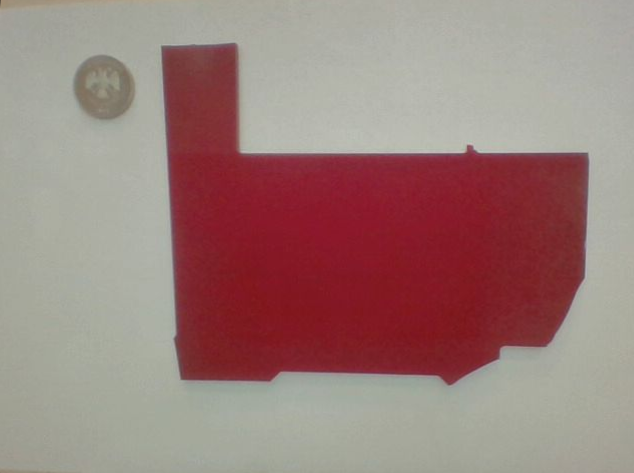

In [0]:
dst2 = cv2.undistort(img2, mtx, dist, None, newcameramtx)

# crop the image
x,y,w2,h2 = roi2
print(roi2)
dst2 = dst2[y:y+h2, x:x+w2]
cv2.imwrite('undist_acrylic.png', dst2)
cv2_imshow(img2)
cv2_imshow(dst2)

# 3. Measuring size

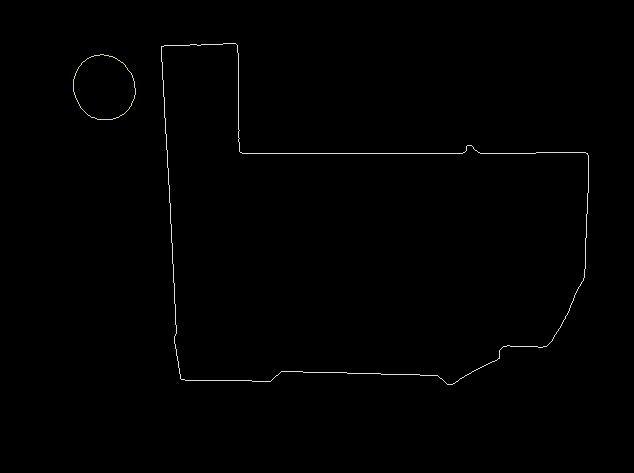

In [0]:
import cv2 as cv
import numpy as np
from google.colab.patches import cv2_imshow # colab-specific function 
import random as rng
from scipy.spatial import distance as dist

width = 25 # reference coin diam: 5RUB == 25mm 


img = cv.imread("undist_chess.png")
gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
gray = cv.GaussianBlur(gray, (7, 7), 0)

# perform edge detection, then perform a dilation + erosion to
# close gaps in between object edges
edges = cv.Canny(gray, 50, 100)
edges = cv.dilate(edges, None, iterations=1)
edges = cv.erode(edges, None, iterations=1)

# find contours in the edge map
_, contours, hierarchy = cv.findContours(edges.copy(), cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
#_, contours, hierarchy = cv.findContours(edges, cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)

drawing = np.zeros((edges.shape[0], edges.shape[1], 3), dtype=np.uint8)
for i in range(len(contours)):
  color = (rng.randint(0,256), rng.randint(0,256), rng.randint(0,256))
  #color = (255, 255, 255)
  cv.drawContours(drawing, contours, i, color, 1, cv.LINE_8, hierarchy, 0)

px_per_mm = None
cv2_imshow(drawing)

Now let's draw bounding boxes around contours 

px_per_mm ratio:2.6 
px_per_mm ratio:2.6 


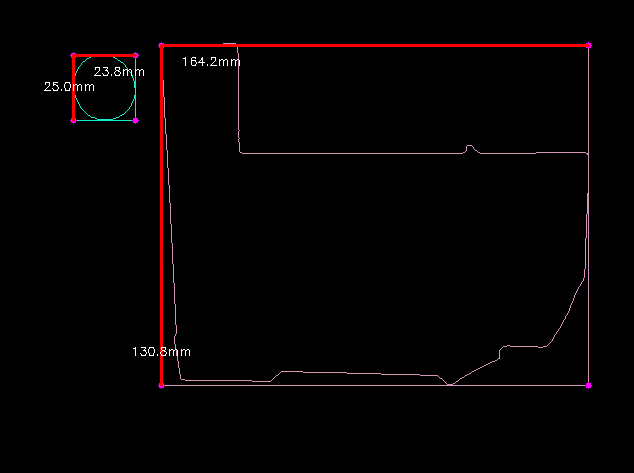

In [0]:
contours_poly = [None]*len(contours)
boundRect = [None]*len(contours)
centers = [None]*len(contours)
radius = [None]*len(contours)
for i, c in enumerate(contours):
  contours_poly[i] = cv.approxPolyDP(c, 3, True)
  boundRect[i] = cv.boundingRect(contours_poly[i])
  centers[i], radius[i] = cv.minEnclosingCircle(contours_poly[i])    
    
drawing_bounds = np.zeros((edges.shape[0], edges.shape[1], 3), dtype=np.uint8)

for i in range(len(contours)):
  color = (rng.randint(0,256), rng.randint(0,256), rng.randint(0,256))
  #cv.drawContours(drawing_bounds, contours_poly, i, color)
  cv.drawContours(drawing_bounds, contours, i, color, 1, cv.LINE_8, hierarchy, 0)
  cv.rectangle(drawing_bounds, (int(boundRect[i][0]), int(boundRect[i][1])), (int(boundRect[i][0]+boundRect[i][2]), int(boundRect[i][1]+boundRect[i][3])), color, 1)
  
  top_left = (int(boundRect[i][0]), int(boundRect[i][1]))
  top_right = (int(boundRect[i][0]+boundRect[i][2]), int(boundRect[i][1]))
  bottom_left = (int(boundRect[i][0]), int(boundRect[i][1]+boundRect[i][3]))
  bottom_right = (int(boundRect[i][0]+boundRect[i][2]), int(boundRect[i][1]+boundRect[i][3]))

  # top left corner point
  cv.circle(drawing_bounds, top_left, 3, (255, 0, 255), -1)
  # top rigth corner point
  cv.circle(drawing_bounds, top_right, 3, (255, 0, 255), -1)
  # bottom left corner point
  cv.circle(drawing_bounds, bottom_left, 3, (255, 0, 255), -1)
  # bottom right corner point
  cv.circle(drawing_bounds, bottom_right, 3, (255, 0, 255), -1)

  rect_w = dist.euclidean(top_left, top_right)
  rect_h = dist.euclidean(top_left, bottom_left)
  
  cv.line(drawing_bounds, top_left, top_right, (0, 0, 255), 2)
  cv.line(drawing_bounds, top_left, bottom_left, (0, 0, 255), 2)

  # init pixelsPerMetric by first contour
  if px_per_mm is None:
    px_per_mm = rect_h / width
  print("px_per_mm ratio:{0} ".format(px_per_mm))
  
  width_mm = rect_w / px_per_mm
  height_mm = rect_h / px_per_mm
  
  # draw the object sizes on the image
  cv.putText(drawing_bounds, "{:.1f}mm".format(width_mm), (top_left[0] + 20, top_left[1] + 20), cv.FONT_HERSHEY_SIMPLEX, 0.4, (255, 255, 255), 1)
  cv.putText(drawing_bounds, "{:.1f}mm".format(height_mm), (bottom_left[0] - 30, bottom_left[1] - 30), cv.FONT_HERSHEY_SIMPLEX,0.4, (255, 255, 255), 1)

cv2_imshow(drawing_bounds)

# 4. Scale vector

In [0]:
contours

In [0]:
scaled_contours = []
for c in contours:
  scaled_cs = c * px_per_mm
  scaled_contours.append(scaled_cs.astype(int))
#scaled_contours

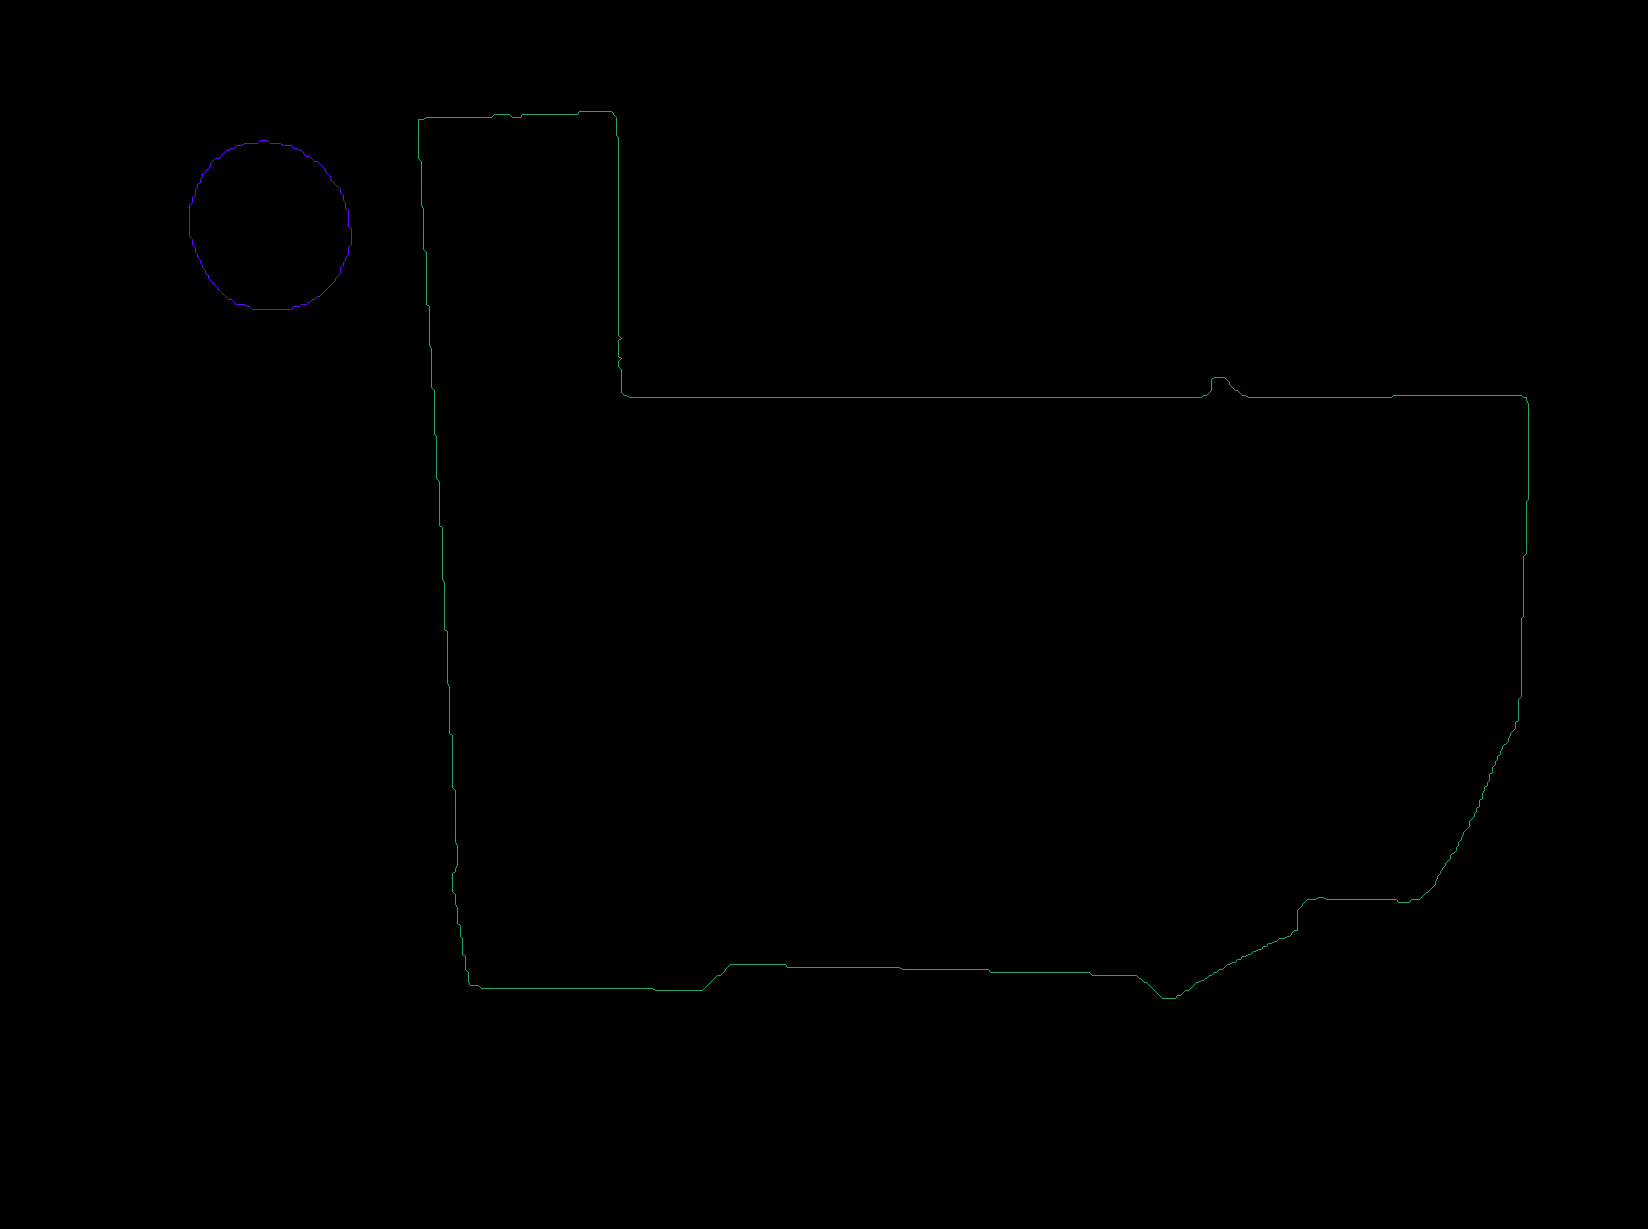

In [0]:
drawing2 = np.zeros((int(edges.shape[0] * px_per_mm), int(edges.shape[1] * px_per_mm), 3), dtype=np.uint8)
for i in range(len(scaled_contours)):
  color = (rng.randint(0,256), rng.randint(0,256), rng.randint(0,256))
  #color = (255, 255, 255)
  cv.drawContours(drawing2, scaled_contours, i, color, 1, cv.LINE_8, hierarchy, 0) # i - number of contour
cv2_imshow(drawing2)

# 5. Save as .SVG

In [0]:
w = 1200
h = 1200

# save all contours
with open("OUTPUT.svg", "w+") as f:
    f.write(f'<svg width="{w}" height="{h}" xmlns="http://www.w3.org/2000/svg">')

    for c in scaled_contours:
        f.write('<path d="M')
        for i in range(len(c)):
            x, y = c[i][0]
            f.write(f"{x} {y} ")
        f.write('" style="stroke:pink"/>')
    f.write("</svg>")